# Rat hexMaze Analysis
The objective of this script is to identify time intervals of interest in rat maze navigation for posterior analysis of neural data. 

The notebook examines a single rat session, exploring:
Speed profiles in each run, U-turns, and deviations or come-backs to optimal (shortest) paths.

In [2]:
## Import functions

import numpy as np  
import pandas as pd
np.set_printoptions(suppress=True) # Supress scientific notation when printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import re # Regular expressions
import networkx as nx # Package for graph represenations 
from datetime import datetime, time 
import pygraphviz as gv

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph, write_dot
from scipy.ndimage.filters import uniform_filter1d

In [3]:
## Set file names and paths

# Read full processed csv file and select rat and session

# SET CORRECT FILENAME!!!!!!!, since import date may differ!!!
filename = '../results/Rat_HM_Ephys_AggProc_20220202.csv'

data_full = pd.read_csv(filename)

# Select Rat and session of interest
selected_rat = 'Rat5'
selected_session = '2021-07-10'

selection = (data_full['rat_no'] == selected_rat) & (data_full['date'] == selected_session)
data = data_full.loc[selection]
print(data)

# Set trial number as index for easy selecting trials
data.set_index('trial_no', inplace=True)

# Set datatype for node as string
data['node'] = data['node'].astype('str')

# Remove Speed artifacts (should be done better)
data['speed_ff'][data['speed_ff']>2]=0

data.info()


     rat_no        date  trial_no  rat_id  node             time  distance  \
941    Rat5  2021-07-10         2  406576   301  00:11:59.520000      0.00   
942    Rat5  2021-07-10         2  406576   302         00:12:05      0.30   
943    Rat5  2021-07-10         2  406576   301  00:12:11.480000      0.30   
944    Rat5  2021-07-10         2  406576   307  00:12:17.920000      0.30   
945    Rat5  2021-07-10         2  406576   301  00:12:21.400000      0.30   
946    Rat5  2021-07-10         2  406576   302  00:12:23.800000      0.30   
947    Rat5  2021-07-10         2  406576   121  00:12:26.560000      1.72   
948    Rat5  2021-07-10         2  406576   122  00:12:27.520000      0.30   
949    Rat5  2021-07-10         2  406576   116  00:12:28.240000      0.30   
950    Rat5  2021-07-10         2  406576   117  00:12:29.160000      0.30   
951    Rat5  2021-07-10         2  406576   110  00:12:29.960000      0.30   
952    Rat5  2021-07-10         2  406576   111  00:12:30.920000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 2 to 20
Data columns (total 17 columns):
rat_no            372 non-null object
date              372 non-null object
rat_id            372 non-null int64
node              372 non-null object
time              372 non-null object
distance          372 non-null float64
seconds_ff        372 non-null float64
speed_ff          372 non-null float64
island            372 non-null object
re-visit          372 non-null bool
u_turn            372 non-null bool
cum_distance      372 non-null float64
cum_seconds       372 non-null float64
act_stps_2trgt    372 non-null int64
min_stps_2trgt    372 non-null int64
nd-visits-day     372 non-null int64
nd-visits-rat     372 non-null int64
dtypes: bool(2), float64(5), int64(5), object(5)
memory usage: 47.2+ KB


C:\Users\Marleen\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Marleen\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Marleen\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Marleen\Anaconda3\lib\site-packages\IPython

### Initial data exploration

#### Time to complete run

Average time to complete run was 41.6 s, with min of 16 and a max of 279 seconds. Trials that stand out as having unusually long times are: **Trial 2, 4**, starting at Easter I. and Hawaii respectively.

#### Speed profile

Plot speed histogram. The histogram seems to reveal two gaussian distributions, which could be interpreted as three speed phases:
1. **Initial acceleration/exploration:** from zero speed to 0.2 or 0.25
2. **Cruise speed:**  from 0.25 to 0.5 
3. **Super certain speed??:** A few extreme values, from 0.5 to 0.8

It's a bit tricky to draw strong conclusions such as these since it depends a lot on how many bins we use to plot the histograms. However, further data exploration below thus suggests that speed 2 occurs once the rat knows where it is going, and its trajectory coincides with optimal trajectory (shortest path). 

From the time to complete trial bar plot, it seems that there is a trend toward faster
trials as time goes by, at least for Japan and Hawaii.



count     18.000000
mean      61.862222
std       95.785263
min       21.120000
25%       24.260000
50%       34.020000
75%       48.540000
max      432.520000
Name: cum_seconds, dtype: float64


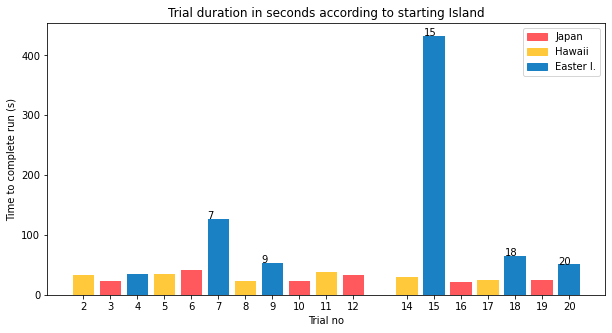

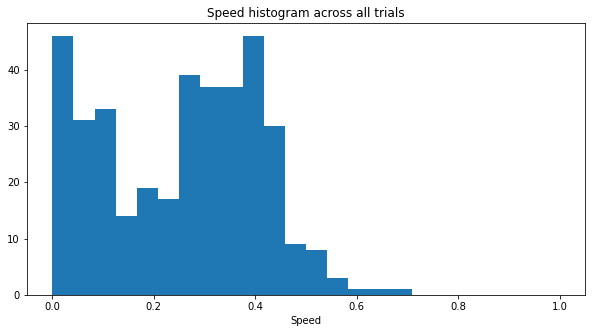

C:\Users\Marleen\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Marleen\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Marleen\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

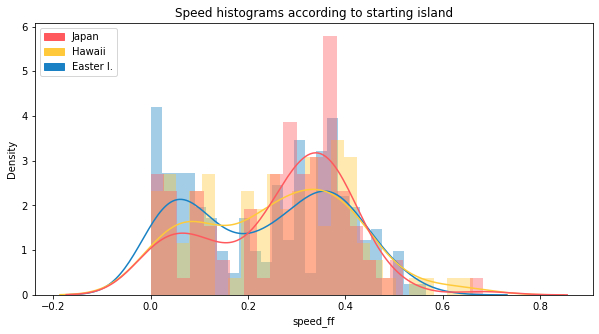

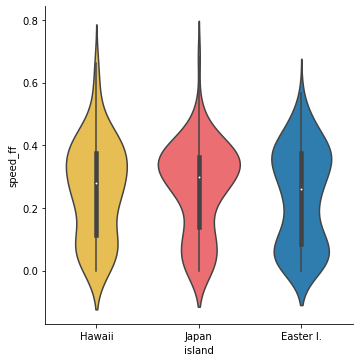

In [4]:
# Overall trial time exploration
# Print some data statistics
print(data.groupby('trial_no')['cum_seconds'].max().describe())

color_map = {'Japan': '#ff595e', 'Hawaii':'#ffca3a', 'Easter I.':'#1982c4', 'Ireland':'#8ac926 '}
color_map_rgb = {'Japan': (1, 0.35, 0.37), 'Hawaii':(1, 0.79, 0.23), \
                 'Easter I.':(0.1, 0.51, 0.77), 'Ireland':(0.54, 0.79, 0.15)}
starting_island = data.groupby('trial_no')['island'].first()
japan_trls = starting_island[starting_island=='Japan'].index
hawaii_trls = starting_island[starting_island=='Hawaii'].index
easter_trls =  starting_island[starting_island=='Easter I.'].index
ireland_trls =  starting_island[starting_island=='Ireland'].index

# Plot a scatter graph labeling longest trials
x = data.index.unique()
y = data.groupby('trial_no')['cum_seconds'].max()
ax = plt.bar(x=x, height=y, color = starting_island.map(color_map_rgb))
plt.title("Trial duration in seconds according to starting Island")
labels = list(color_map.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_map_rgb[label]) for label in labels]
# Don't include last item of labels and handles, corresponding to target island IRELAND
# Since we're plotting starting island, and no trials start in the target island.
plt.legend(handles[:-1], labels[:-1])
plt.xticks(x)


# Annotate longest trials
tr_labels = [str(tr) if data.loc[tr,'cum_seconds'].max()>50 
          else "" for tr in data.index.unique() ] 
for i, txt in enumerate(tr_labels):
    plt.annotate(txt, (ax.patches[i].get_x(), y.tolist()[i]))
plt.ylabel('Time to complete run (s)')
plt.xlabel('Trial no')

plt.pause(0.5)

# Speed histogram
plt.hist(data['speed_ff'], bins=np.linspace(0,1,25));
plt.xlabel('Speed')
plt.title("Speed histogram across all trials")
plt.show()
sns.distplot(data.loc[easter_trls, 'speed_ff'], bins=25, color= '#1982c4')
sns.distplot(data.loc[hawaii_trls, 'speed_ff'], bins=25, color = '#ffca3a')
sns.distplot(data.loc[japan_trls, 'speed_ff'], bins=25, color = '#ff595e')
sns.distplot(data.loc[ireland_trls, 'speed_ff'], bins=25, color = '#ff597e')
plt.title("Speed histograms according to starting island")
plt.legend(handles[:-1], labels[:-1])

# Speed box plots according to island
sns.catplot(y = "speed_ff", x = starting_island, data = data, 
            kind = "violin", palette=color_map_rgb)
plt.title("Violin plots for speed according to starting island")

372


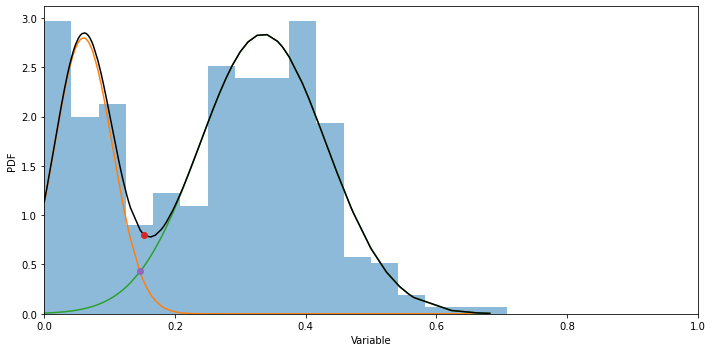

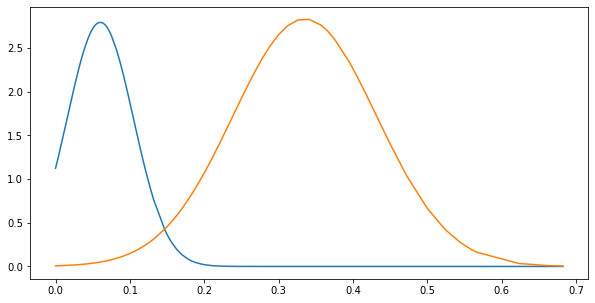

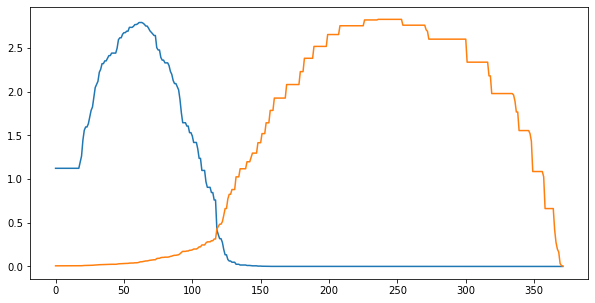

In [5]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema
from scipy import signal


gmm = GaussianMixture(n_components = 2).fit(np.asarray(data['speed_ff']).reshape(-1, 1))

plt.figure()
plt.hist(data['speed_ff'], bins=np.linspace(0,1,25), histtype='stepfilled', density = True, alpha=0.5)
plt.xlim(0, 1)
f_axis = data['speed_ff'].copy().ravel()
f_axis.sort()
a = []
b = []
for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    a.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
    plt.plot(f_axis, a[-1])
    b.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())

print(len(b[0]))


plt.plot(f_axis, np.array(a).sum(axis =0), 'k-')
plt.xlabel('Variable')
plt.ylabel('PDF')
plt.tight_layout()

#print(max(np.array(a).sum(axis = 0)))

plt.plot(f_axis[121],np.array(a).sum(axis = 0)[121], 'o')
plt.plot(f_axis[118], b[1][118],'o')

plt.figure()
plt.plot(f_axis,b[0])
plt.plot(f_axis,b[1])
plt.figure()
plt.plot(b[0])
plt.plot(b[1])


[-0.33913456]
[0.33913456]
[0.]


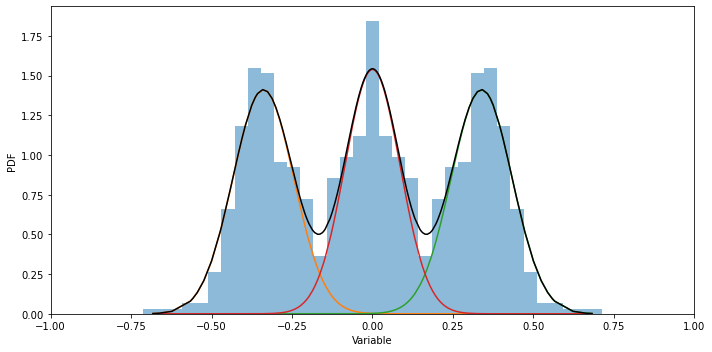

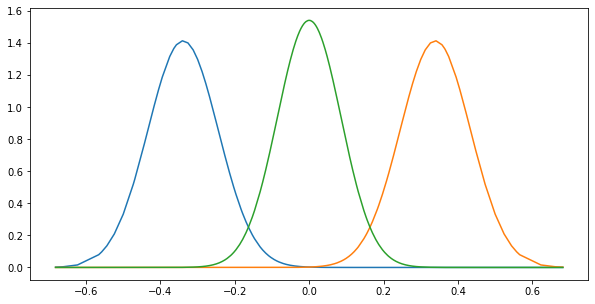

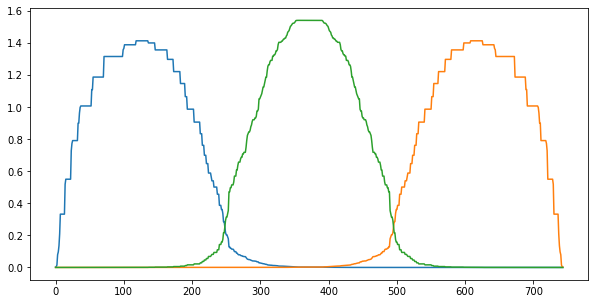

In [6]:
sp = data['speed_ff']*-1

sptotal = pd.concat([data['speed_ff'],(sp)])

gmm2 = GaussianMixture(n_components = 3).fit(np.asarray(sptotal).reshape(-1, 1))

plt.figure()
plt.hist(sptotal, bins=np.linspace(-1,1,50), histtype='stepfilled', density = True, alpha=0.5)
plt.xlim(-1, 1)
f_axis1 = sptotal.copy().ravel()
f_axis1.sort()
a = []
c = []
for weight, mean, covar in zip(gmm2.weights_, gmm2.means_, gmm2.covariances_):
    a.append(weight*norm.pdf(f_axis1, mean, np.sqrt(covar)).ravel())
    plt.plot(f_axis1, a[-1])
    print(mean)
    c.append(weight*norm.pdf(f_axis1, mean, np.sqrt(covar)).ravel())
    #print(gmm2.means_)
plt.plot(f_axis1, np.array(a).sum(axis =0), 'k-')
plt.xlabel('Variable')
plt.ylabel('PDF')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f_axis1,c[0])
plt.plot(f_axis1,c[1])
plt.plot(f_axis1,c[2])
plt.figure()
plt.plot(c[0])
plt.plot(c[1])
plt.plot(c[2])

[-0.16338227] [0.25088567]


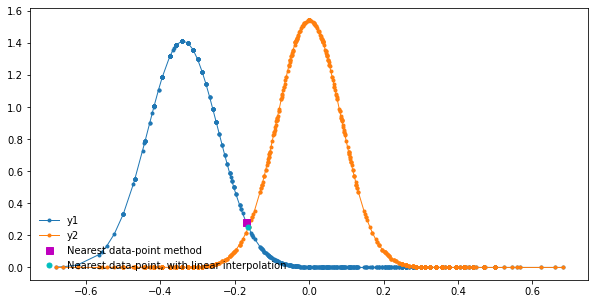

In [7]:
from __future__ import division 

def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the second line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y
        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc.flatten(),yc.flatten()

   
#For the model with 3 Gaussians
x_ax  = f_axis1
y1 = c[0]
y2 = c[2]

plt.plot(x_ax, y1, marker='o', mec='none', ms=4, lw=1, label='y1')
plt.plot(x_ax, y2, marker='o', mec='none', ms=4, lw=1, label='y2')

idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)

plt.plot(x_ax[idx], y1[idx], 'ms', ms=7, label='Nearest data-point method')

# new method!
xc, yc = interpolated_intercept(x_ax,y1,y2)
plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')
print(xc,yc)


plt.legend(frameon=False, fontsize=10, numpoints=1, loc='lower left')

plt.show()

In [24]:
def intersectionPoint(ratNr):
    
    dataRatNr = data_full.loc[data_full['rat_no']==ratNr]
    dates = dataRatNr['date'].unique()
    meanIntersection = list()
    mean1 = list()
    mean2 = list()
    intersectionPoint = list()
    
    for i in dates:
        dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==i)]
        sp = dataRatSession['speed_ff']*-1

        sptotal = pd.concat([dataRatSession['speed_ff'],(sp)])

        gmm2 = GaussianMixture(n_components = 3).fit(np.asarray(sptotal).reshape(-1, 1))
        
        #plt.figure()
        #plt.hist(sptotal, bins=np.linspace(-1,1,50), histtype='stepfilled', density = True, alpha=0.5)
        #plt.xlim(-1, 1)
        
        f_axis1 = sptotal.copy().ravel()
        f_axis1.sort()
        a = []
        c = []
        for weight, mean, covar in zip(gmm2.weights_, gmm2.means_, gmm2.covariances_):
            a.append(mean)
            c.append(weight*norm.pdf(f_axis1, mean, np.sqrt(covar)).ravel())
            #plt.plot(f_axis1, c[-1])
            
        #plt.plot(f_axis1, np.array(c).sum(axis =0), 'k-')
        #plt.xlabel('Variable')
        #plt.ylabel('PDF')
        #plt.tight_layout()
        #plt.show()
        a=np.asarray(a)
        
        g1=np.argmin(abs(a))
        g2=np.argmax(a)

        a = (a[g1],a[g2])
        c = (c[g1],c[g2])
        
        x_axis  = f_axis1
        y1 = c[0]
        y2 = c[1]
        #plt.plot(x_axis, y1, marker='o', mec='none', ms=4, lw=1, label='y1')
        #plt.plot(x_axis, y2, marker='o', mec='none', ms=4, lw=1, label='y2')
        idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
       

        #plt.plot(x_axis[idx], y1[idx], 'ms', ms=7, label='Nearest data-point method')
        y1 = y1[x_axis>0]
        y2 = y2[x_axis>0]
        x_axis = x_axis[x_axis>0]
        xc, yc = interpolated_intercept(x_axis,y1,y2)
        #plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')
        mean1.append(a[0])
        mean2.append(a[1])
        intersectionPoint.append((xc,yc))
        meanIntersection.append((a[0].flatten(),(xc.flatten(),yc.flatten()), a[1].flatten()))
    return mean1 , mean2, intersectionPoint, dates, dataRatNr
mean1,mean2,intersectionP, dateD, dataRatNr = intersectionPoint('Rat5')
#print(intersectionPoint('Rat5'))

# Plotting in time the averages of the intersection point and means per session.
# Calculating the intersection point of average point within trials (min aantal puntnen?)

[array([0.16087066]), array([0.17783625]), array([0.16338227]), array([0.16134963]), array([0.1865558]), array([0.14360431])]
['2021-06-28' '2021-06-29' '2021-07-10' '2021-07-11' '2021-07-13'
 '2021-07-15']


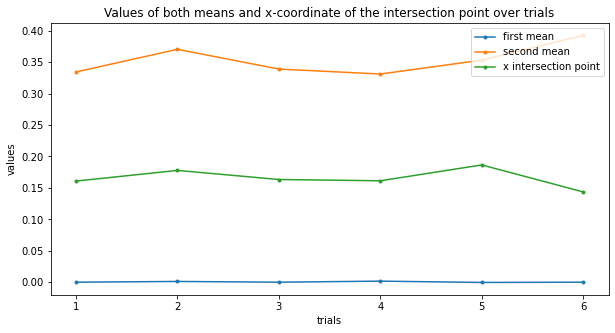

In [25]:
means1G, means2G, intersectionP, dateD, dataRatNr = intersectionPoint('Rat5')

trials = np.linspace(1,len(means1G), num = len(means1G))
iP = list()
for i in range(len(intersectionP)):
    iP.append(intersectionP[i][0][0].flatten())

print(iP)    
print(dateD)
plt.figure()
plt.title('Values of both means and x-coordinate of the intersection point over trials')
plt.plot(trials, means1G, label ='first mean', marker = '.')
plt.plot(trials, means2G, label ='second mean', marker = '.')
plt.plot(trials, iP, label='x intersection point', marker = '.')
plt.legend(loc = 1)
plt.xlabel('trials')
plt.ylabel('values')
plt.show()

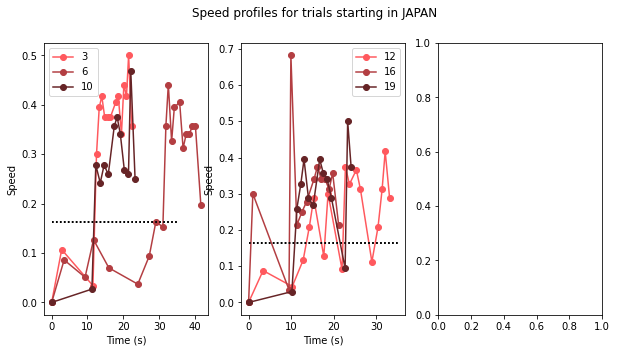

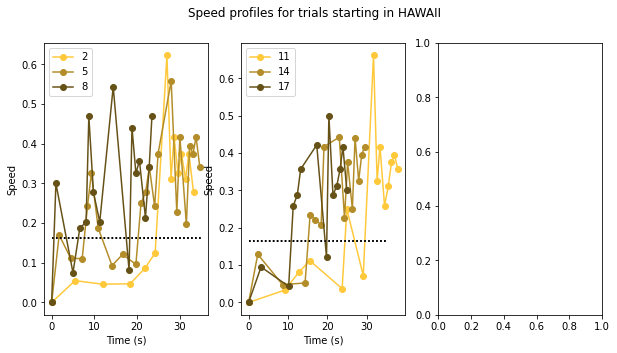

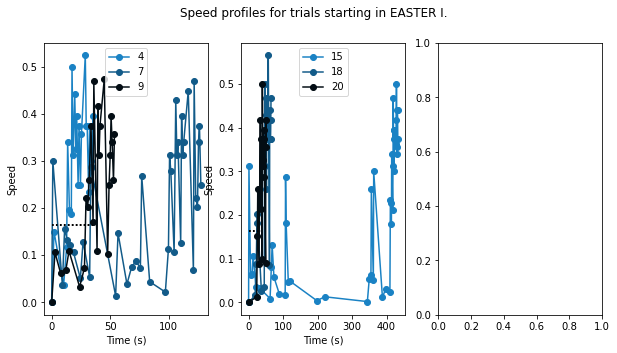

    trial_number    time  index intersection_node goal_node
6              2   28.00      7               122       104
0              3   14.80      6               203       104
12             4   15.16      5               409       104
7              5   10.92      6               324       104
1              6   33.48     11               202       104
13             7  101.64     22               407       104
8              8    9.80      6               301       104
14             9   30.80      8               407       104
2             10   13.56      3               203       104
9             11   32.60      8               122       104
3             12   23.64     10               201       104
10            14   16.96      5               307       104
15            15  108.72     14               409       104
4             16   11.32      4               203       104
11            17   21.40      9               117       104
16            18   47.76      9         

In [26]:
#See at what time point, there are two consecutive point above the dotted line. 

## JAPAN

nlines = 3
ncols = int(len(japan_trls)/nlines)
listAtWhatSpeedCrossesLine = list()
listSpeed = list()
listTimes = list()
indexList = list()
goalNodeList = list()
trialNumberList = list()
intersectionNodeList = list()
d = list(dateD).index(selected_session)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Japan'], \
              tuple([0.7*x for x in color_map_rgb['Japan']]), \
              tuple([0.4*x for x in color_map_rgb['Japan']])]
    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = japan_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 35], [iP[d],iP[d]], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Japan, so third plot should only have 1 line
            
            q = 0
            p = 0
            b = data.loc[tr,'speed_ff']
            #print(b)
            i = -1
            for j in b:
                if(j<=i and j>=iP[d]):
                    listAtWhatSpeedCrossesLine.append((tr, j))
                    if q==0:
                        trialNumberList.append(tr)
                        listSpeed.append((tr,j))
                        listTimes.append(data.loc[tr,'cum_seconds'].iloc[p])
                        indexList.append(p)
                        goalNodeList.append(data.loc[tr,'node'].iloc[-1])
                        intersectionNodeList.append(data.loc[tr,'node'].iloc[p]) 
                    q+=1   
                i=j
                p+=1
        it += nlines

    plt.suptitle('Speed profiles for trials starting in JAPAN')           
    plt.show()    

#print(listSpeed)  
#print('---------------')
#print(listAtWhatSpeedCrossesLine)   
#print(listTimes)


###The dotted lines (the average intersection point) is not yet calculated per starting island. Still have to do that.

###List of trialnumber, time, index, intersection node, goal node

# res = pd.DataFrame(list(zip(trialNumberList, listTimes, indexList, intersectionNodeList, goalNodeList)),
#                columns =['trial_number', 'time', 'index', 'intersection_node', 'goal_node'])
# print(res)


## HAWAII
nlines = 3
ncols = int(len(hawaii_trls)/nlines)
if ncols>0:

    it = 0
    colors = [color_map_rgb['Hawaii'], \
              tuple([0.7*x for x in color_map_rgb['Hawaii']]), \
              tuple([0.4*x for x in color_map_rgb['Hawaii']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = hawaii_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color=colors[line]);
            ax[col].plot([0, 35], [iP[d],iP[d]], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Hawaii, so third plot should only have 1 line
        
            q = 0
            p = 0
            b = data.loc[tr,'speed_ff']
            i = -1
            for j in b:
                if(j<=i and j>=iP[d]):
                    listAtWhatSpeedCrossesLine.append((tr, j))
                    if q==0:
                        trialNumberList.append(tr)
                        listSpeed.append((tr,j))
                        listTimes.append(data.loc[tr,'cum_seconds'].iloc[p])
                        indexList.append(p)
                        goalNodeList.append(data.loc[tr,'node'].iloc[-1])
                        intersectionNodeList.append(data.loc[tr,'node'].iloc[p]) 
                    q+=1   
                i=j
                p+=1
        
        it += nlines
    plt.suptitle('Speed profiles for trials starting in HAWAII') 
    plt.show()
    
    

## EASTER I.
nlines = 3
ncols = int(len(easter_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = easter_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
            ax[col].plot([0, 35], [iP[d],iP[d]], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
            
            q = 0
            p = 0
            b = data.loc[tr,'speed_ff']
            i = -1
            for j in b:
                if(j<=i and j>=iP[d]):
                    listAtWhatSpeedCrossesLine.append((tr, j))
                    if q==0:
                        trialNumberList.append(tr)
                        listSpeed.append((tr,j))
                        listTimes.append(data.loc[tr,'cum_seconds'].iloc[p])
                        indexList.append(p)
                        goalNodeList.append(data.loc[tr,'node'].iloc[-1])
                        intersectionNodeList.append(data.loc[tr,'node'].iloc[p]) 
                    q+=1   
                i=j
                p+=1
                
        it += nlines
    plt.suptitle('Speed profiles for trials starting in EASTER I.') 
    plt.show()
    


    
## IRELAND 
nlines = 3
ncols = int(len(ireland_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = ireland_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
            ax[col].plot([0, 35], [iP[d],iP[d]], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
                
            q = 0
            p = 0
            b = data.loc[tr,'speed_ff']
            i = -1
            for j in b:
                if(j<=i and j>=iP[d]):
                    listAtWhatSpeedCrossesLine.append((tr, j))
                    if q==0:
                        trialNumberList.append(tr)
                        listSpeed.append((tr,j))
                        listTimes.append(data.loc[tr,'cum_seconds'].iloc[p])
                        indexList.append(p)
                        goalNodeList.append(data.loc[tr,'node'].iloc[-1])
                        intersectionNodeList.append(data.loc[tr,'node'].iloc[p]) 
                    q+=1   
                i=j
                p+=1   
                
                
        it += nlines
    plt.suptitle('Speed profiles for trials starting in IRELAND.') 
    plt.show()
    
# print(listSpeed)  
# print('---------------')
# print(listAtWhatSpeedCrossesLine) 

res = pd.DataFrame(list(zip(trialNumberList, listTimes, indexList, intersectionNodeList, goalNodeList)),
               columns =['trial_number', 'time', 'index', 'intersection_node', 'goal_node'])
res.sort_values(by = ['trial_number'], ascending=True, inplace = True)
res.drop_duplicates(subset='trial_number', keep = False, inplace = True)
print(res)

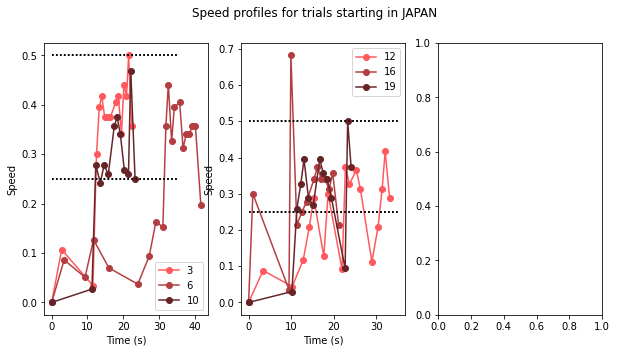

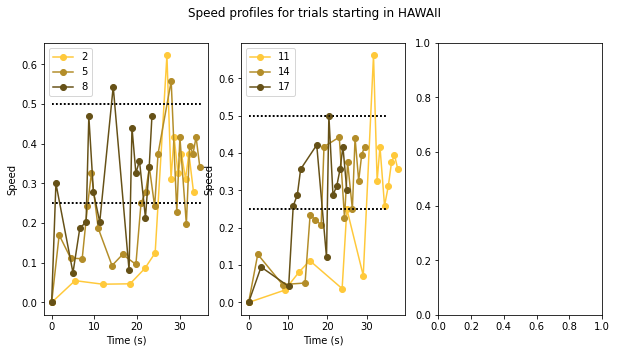

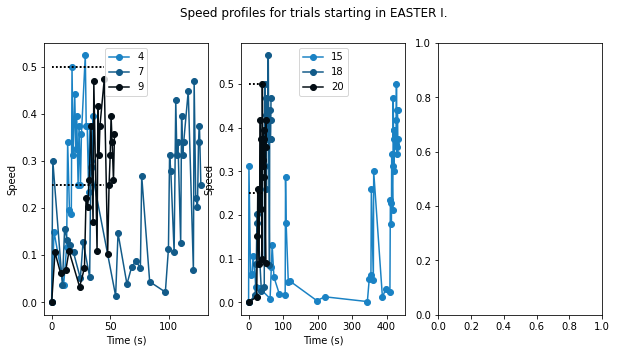

In [27]:
## Speed line plots with fewer trials per plot to have a better look

## JAPAN

nlines = 3
ncols = int(len(japan_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Japan'], \
              tuple([0.7*x for x in color_map_rgb['Japan']]), \
              tuple([0.4*x for x in color_map_rgb['Japan']])]
    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = japan_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 35], [0.25, 0.25], 'k:')
            ax[col].plot([0, 35], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Japan, so third plot should only have 1 line
        it += nlines

    plt.suptitle('Speed profiles for trials starting in JAPAN')           
    plt.show()

## HAWAII
nlines = 3
ncols = int(len(hawaii_trls)/nlines)
if ncols>0:

    it = 0
    colors = [color_map_rgb['Hawaii'], \
              tuple([0.7*x for x in color_map_rgb['Hawaii']]), \
              tuple([0.4*x for x in color_map_rgb['Hawaii']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = hawaii_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color=colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 35], [0.25, 0.25], 'k:')
            ax[col].plot([0, 35], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if col == 2: break; # There are 7 trials in Hawaii, so third plot should only have 1 line
        it += nlines
    plt.suptitle('Speed profiles for trials starting in HAWAII') 
    plt.show()

## EASTER I.
nlines = 3
ncols = int(len(easter_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = easter_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 45], [0.25, 0.25], 'k:')
            #ax[col].plot([0, 45], [0.25088567, 0.25088567], 'k:')
            ax[col].plot([0, 45], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
        it += nlines
    plt.suptitle('Speed profiles for trials starting in EASTER I.') 
    plt.show()

## IRELAND 
nlines = 3
ncols = int(len(ireland_trls)/nlines)
if ncols>0:
    it = 0
    colors = [color_map_rgb['Easter I.'], \
              tuple([0.7*x for x in color_map_rgb['Easter I.']]), \
              tuple([0.1*x for x in color_map_rgb['Easter I.']])]

    fig, ax = plt.subplots(1, ncols+1)
    for col in range(ncols):
        for line in range(nlines):
            tr = ireland_trls[line+it]
            ax[col].plot(data.loc[tr, 'cum_seconds'], data.loc[tr, 'speed_ff'],\
                              label=str(tr), marker = 'o', color = colors[line]);
             #Add hypothetical speed phase boundaries
            ax[col].plot([0, 45], [0.25, 0.25], 'k:')
            ax[col].plot([0, 45], [0.5, 0.5], 'k:')
            ax[col].set_xlabel('Time (s)');
            ax[col].set_ylabel('Speed');
            ax[col].legend();
            if (line == 1) & (col == 2): break;
        it += nlines
    plt.suptitle('Speed profiles for trials starting in IRELAND.') 
    plt.show()

### U-turns and deviation from optimal (shortest) path

We will now look for U-turns and examine deviation from optimal (shortest path).

We find there are 6 u-turns, one in each trial: trial_nos: 2, 5, 10, 13, 16 and 24. U-turns always occur in starting island: In the bar chart, bar colour indicates starting island. In turn, each bar is annotated with the U-turn node and the island it belongs to. Both things co-incide.

We realise re-visiting a node could be an interesting moment, even if it is not an immediate u-turn. We look for duplicate nodes in the trajectory. Trials 2 and 4, which are also the longest, have several re-visits.

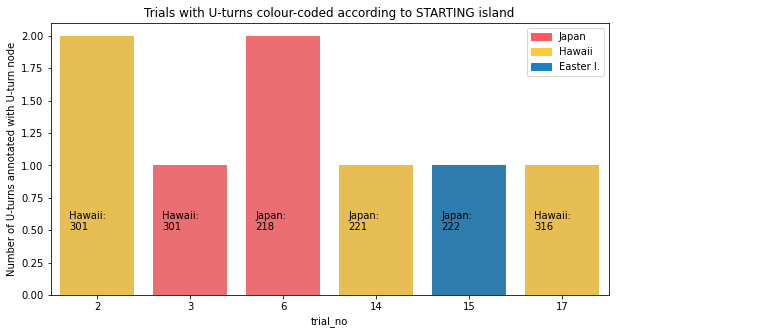

In [28]:
# Plot number of u-turns per trial.
# I need to reset index, so that trial_no is a standard column and I can plot it
u_turns = data[data['u_turn'] == True].reset_index()

sns.countplot(x='trial_no', data=u_turns,\
             palette = starting_island[u_turns['trial_no'].unique()].map(color_map_rgb).values)
plt.title('Trials with U-turns colour-coded according to STARTING island')
plt.ylabel('Number of U-turns annotated with U-turn node')
plt.legend(handles[:-1], labels[:-1])

# Annotate longest trials
tr_label_1 = u_turns['island'].to_list()
tr_label_2 = u_turns['node'].to_list()
for i, txt1 in enumerate(tr_label_1):
    txt = txt1 + ':\n' + tr_label_2[i]
    plt.annotate(txt, (i-0.3, 0.5))

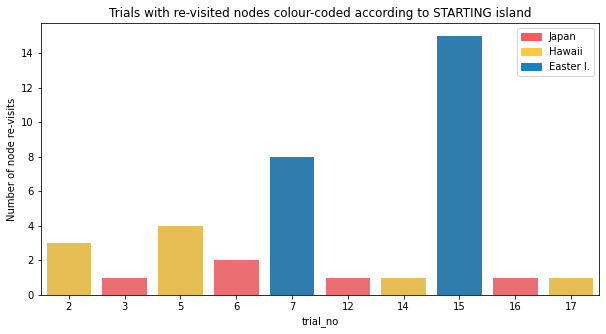

In [29]:
# Plot number of re-visits per trial.
# I need to reset index, so that trial_no is a standard column and I can plot it
re_visited = data[data['re-visit'] == True].reset_index()

sns.countplot(x='trial_no', data=re_visited, \
             palette = starting_island[re_visited['trial_no'].unique()].map(color_map_rgb).values)
plt.title('Trials with re-visited nodes colour-coded according to STARTING island')
plt.ylabel('Number of node re-visits')
plt.legend(handles[:-1], labels[:-1])

## Shortest distance plots

Some observations:

- In ***Trial 2***, rat seems pretty lost in Japan, although starting island is Easter. I.
- At bridges, rat seems to always speed-up

ValueError: cannot reindex from a duplicate axis

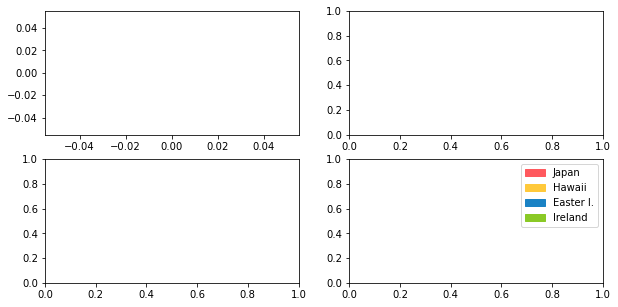

In [30]:
# Plot u_turns and re-visited nodes in shortest distance plots

# Generate list of labels to annotate plots
lbls = []
for i, node in enumerate(data['node'].astype('str')):
    if data.iloc[i]['u_turn']== True:
        lbls.append('U_TURN: ' + node)
    elif data.iloc[i]['re-visit'] == True:
        lbls.append('RE: ' + node)
    else:
        lbls.append("")

# Distribute plots in two columns
n_cols = 2
n_rows = 2 #int(len(data.index.unique())/n_cols +0.5) #(add 0.5 to round upwards)
n_tr = 0
tr = 0

while tr < data.index.unique().max():
    fig, ax = plt.subplots(n_rows, n_cols)
    plt.legend(handles, labels)
   
    for row in range(n_rows):
        for col in range(n_cols):
            if n_tr == len(data.index.unique()):
                break
            tr = data.index.unique()[n_tr]
            x = list(range(0, len(data.loc[tr])))
            y = data.loc[tr, 'min_stps_2trgt']

            sns.lineplot(ax=ax[row, col], x=x, \
                            y ='min_stps_2trgt', hue='island', marker = 'o',\
                            data = data.loc[tr], palette = color_map_rgb, label=str(tr), legend=False)
            
            trl_idx = [i for i, is_true in enumerate(data.index == tr) if is_true]
            for j, i in enumerate(trl_idx):
                ax[row, col].annotate(lbls[i], (x[j], y.iloc[j]))

            ax[row, col].set_title('Trial ' + str(tr))
            #ax[row, col].legend();

            ax2=ax[row, col].twinx()
            # make a plot with different y-axis using second axis object
            ax2.plot(x, data.loc[tr, 'speed_ff'], \
                           color="gray",marker="x")
            

            # Add hypothetical speed phase boundaries
            ax2.plot([0, max(x)], [0.25, 0.25], 'k:')
            ax2.plot([0, max(x)], [0.5, 0.5], 'k:')

            n_tr += 1
            
            
        ax2.set_ylabel("Speed", color="gray", fontsize=14)
        ax[row, col-1].set_ylabel('Shortest distance', color="blue",fontsize=14);
        
    ax[1, 0].set_xlabel('Step');
    ax[1, 1].set_xlabel('Step');
    


            #plt.show()
    
    
   
    #plt.pause(0.3)        
        

C:\Users\Marleen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Deviation from optimal path coloured according to starting island')

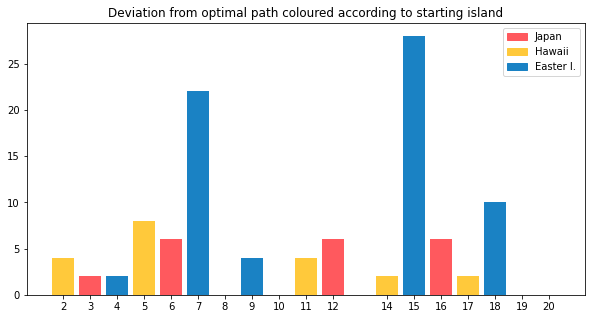

In [31]:
# Now plot deviation from shortest path for each trial as a bar graph, and add
# deviation value as a new column in dataframe

data['deviation'] = data['act_stps_2trgt'] - data['min_stps_2trgt']

x = data.index.unique()
y = data.groupby('trial_no')['deviation'].first()

plt.bar(x, y, color = starting_island.map(color_map_rgb))
plt.xticks(x)
plt.legend(handles[:-1], labels[:-1])
plt.title("Deviation from optimal path coloured according to starting island")
# I love that there seem to be cyclic oscillations in performance!!

In [32]:
edgelist_filename = '../data/graph_edgelist.dat'

### load graph
print("load graph")
G = nx.read_edgelist(edgelist_filename)  
print("graph: number of nodes = ",G.number_of_nodes(),", edges = ",G.number_of_edges())

### pre-compute all possible shortest path lengths and save in dictionary (does not save shortest paths itself)
DD = nx.shortest_path_length(G) 
DD = dict(DD)
print("dictionary: len =", len(DD), ", total items =", sum([len(dv) for dv in DD.values()]))

# get node positions from recosntructed graph 
pos = graphviz_layout(G)

load graph
graph: number of nodes =  96 , edges =  125
dictionary: len = 96 , total items = 9216


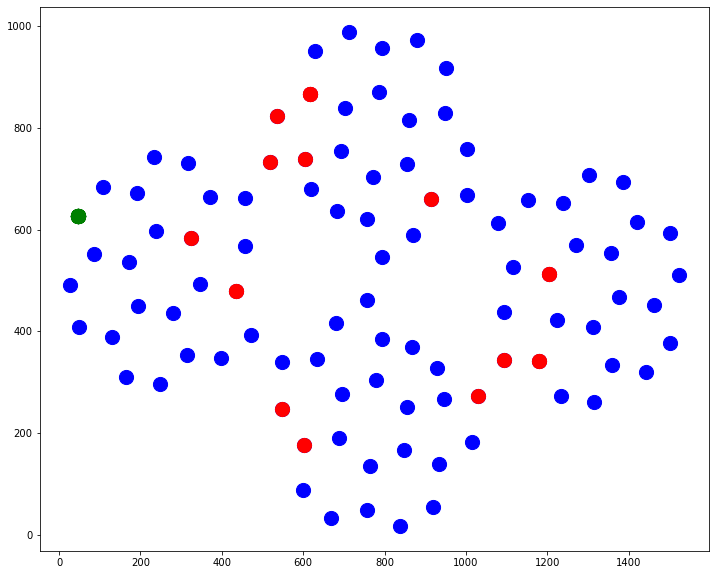

In [33]:
plt.figure(figsize=(12,10))

sp_th = 0.3

for nn in pos.keys():
    plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')


# Plot with node labels

#for tr in data.index.unique():
for tr in range(len(res)):
    #print(tr)
#     speed = data.loc[tr,'speed_ff']
#     speed_tr = uniform_filter1d(speed,size=5)
#     y = speed_tr
#     f_nodes = np.argwhere(y>sp_th) 
    #node_lbls = data.loc[tr,'node'].array
    #print(node_lbls)
    #if tr==res.loc['trial_number'].iloc[tr]:
    node_lbls = res.loc[tr,'intersection_node']
    node_goal = res.loc[tr,'goal_node']
    #print(node_lbls)
    #if(len(f_nodes)>0):
    #    node_lbls = node_lbls[f_nodes[0]]  #
    #print(node_lbls)
    #for nn in range(len(node_lbls)):#
        #plt.scatter(pos[str(node_lbls[nn])][0],pos[str(node_lbls[nn])][1],s=200,c='red')#
    plt.scatter(pos[node_lbls][0],pos[node_lbls][1],s=200,c='red')#
    plt.scatter(pos[node_goal][0],pos[node_goal][1],s=200,c='green')#
plt.show() 


In [34]:
res.loc[0,'intersection_node']

'203'

In [35]:
len(res)

18

In [36]:
#Zorg dat je alleen ratnummer en sessie (of alleen ratnummer) (of een paar) kan inputten en het hele script dan runt
#En kijk of je dan kan kijken of er overlappende intersection nodes in zitten. 
#En kijk even of er iets leuks gedaan kan worden met kleuren. 

In [63]:
def getnewDataframe (dataR, sessionNumber, ratNr):
    listAtWhatSpeedCrossesLine = list()
    listSpeed = list()
    listTimes = list()
    indexList = list()
    goalNodeList = list()
    trialNumberList = list()
    intersectionNodeList = list()
    listSessionNumber = list()
    dates = dataRatNr['date'].unique()
    if sessionNumber==0:
        for z in dates:
            dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==z)]
            dataRatSession.set_index('trial_no', inplace=True)
            tr_list = dataRatSession.index.unique()
            for tr in tr_list:
                q = 0
                p = 0
                b = dataRatSession.loc[tr, 'speed_ff']
                i = -1
                for j in b:
                        print(d)
                        if(j<=i and j>=iP[d]):
                            listAtWhatSpeedCrossesLine.append((tr, j))
                            if q==0:
                                trialNumberList.append(tr)
                                listSpeed.append((tr,j))
                                listTimes.append(dataRatSession.loc[tr,'cum_seconds'].iloc[p])
                                indexList.append(p)
                                goalNodeList.append(dataRatSession.loc[tr,'node'].iloc[-1])
                                intersectionNodeList.append(dataRatSession.loc[tr,'node'].iloc[p]) 
                                listSessionNumber.append(z)
                            q+=1   
                        i=j
                        p+=1

    else:
        dataRatSession = data_full.loc[(data_full['rat_no']==ratNr) & (data_full['date']==sessionNumber)]
        dataRatSession.set_index('trial_no', inplace=True)
        tr_list = dataRatSession.index.unique()
        for tr in tr_list:
            q = 0
            p = 0
            b = dataRatSession.loc[tr,'speed_ff']
            i = -1
            for j in b:
                    print(d)
                    if(j<=i and j>=iP[d]):
                        listAtWhatSpeedCrossesLine.append((tr, j))
                        if q==0:
                            trialNumberList.append(tr)
                            listSpeed.append((tr,j))
                            listTimes.append(dataRatSession.loc[tr,'cum_seconds'].iloc[p])
                            indexList.append(p)
                            goalNodeList.append(dataRatSession.loc[tr,'node'].iloc[-1])
                            intersectionNodeList.append(dataRatSession.loc[tr,'node'].iloc[p]) 
                            listSessionNumber.append(sessionNumber)
                        q+=1   
                    i=j
                    p+=1
                    
    res = pd.DataFrame(list(zip(trialNumberList, listTimes, indexList, intersectionNodeList, goalNodeList,listSessionNumber)),
               columns =['trial_number', 'time', 'index', 'intersection_node', 'goal_node','session_number'])
    res.sort_values(by = ['session_number', 'trial_number'], ascending=[True,True], inplace = True)
    res.drop_duplicates(subset=['session_number','trial_number'],keep=False, inplace = True)
    return res

In [64]:
def getInfoRat(ratNr, sessionNr):
    mean1,mean2,intersection_point, session_number, dataRatNr = intersectionPoint(ratNr)
    df = getnewDataframe(dataRatNr, sessionNr, ratNr)
    cf = df.copy()
    cf = cf.groupby(['intersection_node'])['intersection_node'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)
    #print(cf)
    return df, cf

In [65]:
dataFram, dictF = getInfoRat('Rat5', 0)
#print(dataFram)
print(dictF)

     trial_number   time  index  intersection_node  goal_node session_number
81              2  25.00      9                323        322     2021-07-13
82              3  23.64     10                202        322     2021-07-13
83              4  10.00      6                401        322     2021-07-13
84              5  18.40      7                202        322     2021-07-13
85              6  10.12      6                401        322     2021-07-13
86              7  15.56      4                120        322     2021-07-13
87              8  47.80     14                123        322     2021-07-13
88              9  10.96      4                303        322     2021-07-13
89             10  18.64      7                323        322     2021-07-13
90             11  19.24      7                202        322     2021-07-13
91             12   7.84      5                116        322     2021-07-13
92             13  11.80      6                201        322     2021-07-13

TypeError: list indices must be integers or slices, not DataFrame

<Figure size 864x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

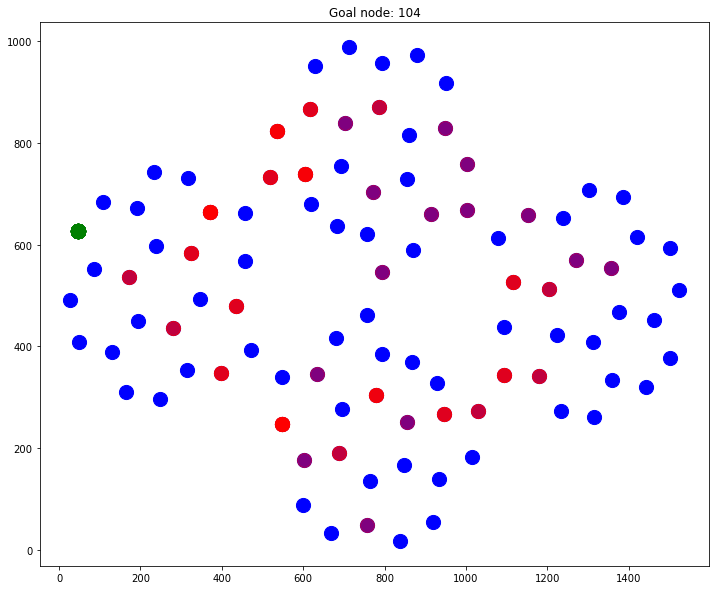

<Figure size 720x360 with 0 Axes>

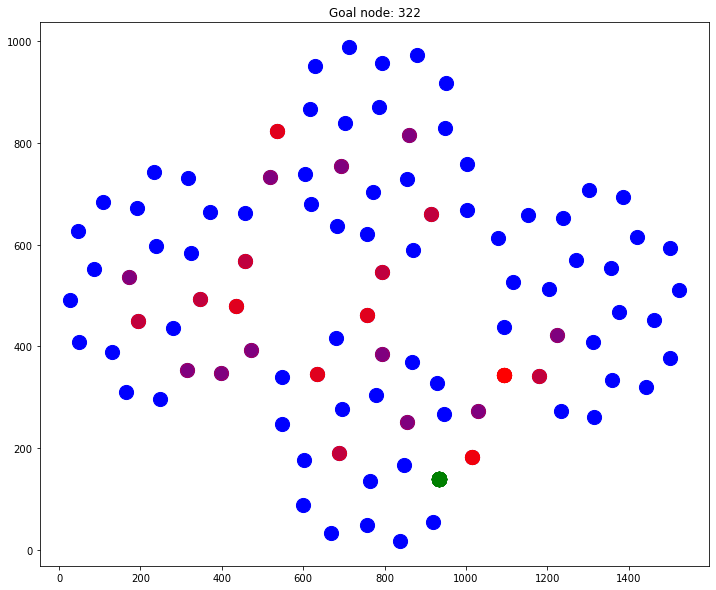

In [53]:
#print(dictF)
#pointS = list(dictF.values())
#print(pointS)
#pointSize = [(np.array(x) * 100).tolist() for x in pointS]
#print(pointSize)

plt.figure(figsize=(12,10))

sp_th = 0.3

#for nn in pos.keys():
#    plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')

#print(len(dataFram))
# print(res)
# for tr in range(len(res)):
#     #print(tr)
#     node_lbls = res.loc[tr,'intersection_node']
#     node_goal = res.loc[tr,'goal_node']
#     #p = 100*np.array(dictF[node_lbls])
#     #plt.scatter(pos[str(node_lbls)][0],pos[str(node_lbls)][1],s=200,c='red')#
#     plt.scatter(pos[node_goal][0],pos[node_goal][1],s=200,c='green')#
    
v=0
#for i in range(len(dataFram)):
    #gn = dataFram['goal_node'].unique()
for j in dataFram['goal_node'].unique():
    plt.figure()
    plt.figure(figsize=(12,10))
    for nn in pos.keys():
        plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')
    sel = (dataFram['goal_node'] == j)
    d = dataFram.loc[sel]
    #print(d)
    for i in (dataFram['session_number'].unique()):
        n = d.loc[dataFram['session_number']==i]
        for tr in range(len(n)):
            node_goal = d.loc[tr+v,'goal_node']
            plt.scatter(pos[str(node_goal)][0],pos[str(node_goal)][1],s=200,c='green',alpha = 1)#
            node_lbls = d.loc[tr+v,'intersection_node']
            #p = 100*np.array(dictF[str(node_lbls)])
            plt.scatter(pos[str(node_lbls)][0],pos[str(node_lbls)][1],s=200,c='red', alpha=0.5)#
            plt.title("Goal node: " + str(node_goal))
        v+=len(n)
plt.show()

In [45]:
node_lbls

401

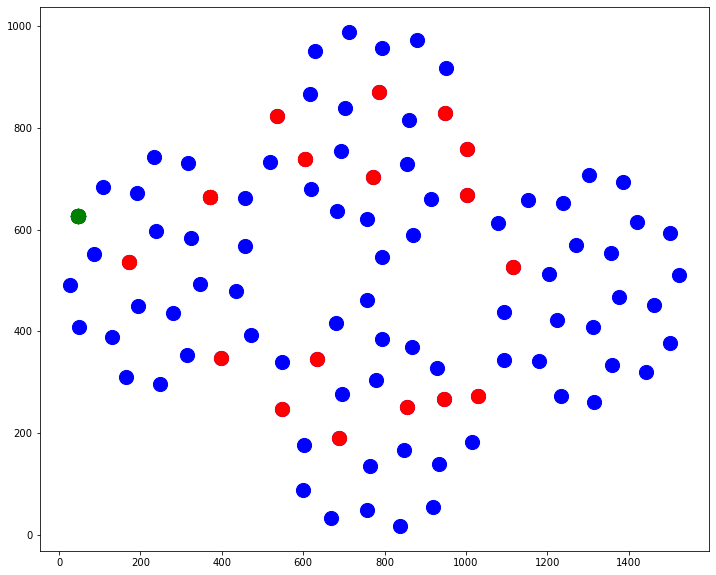

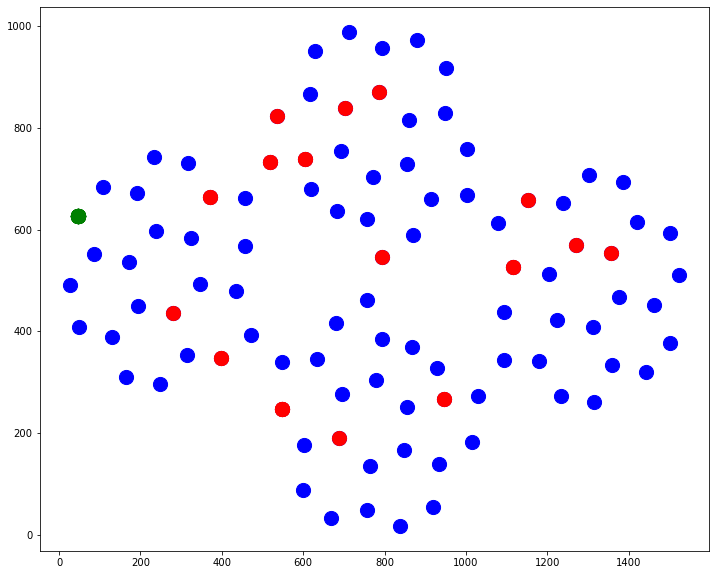

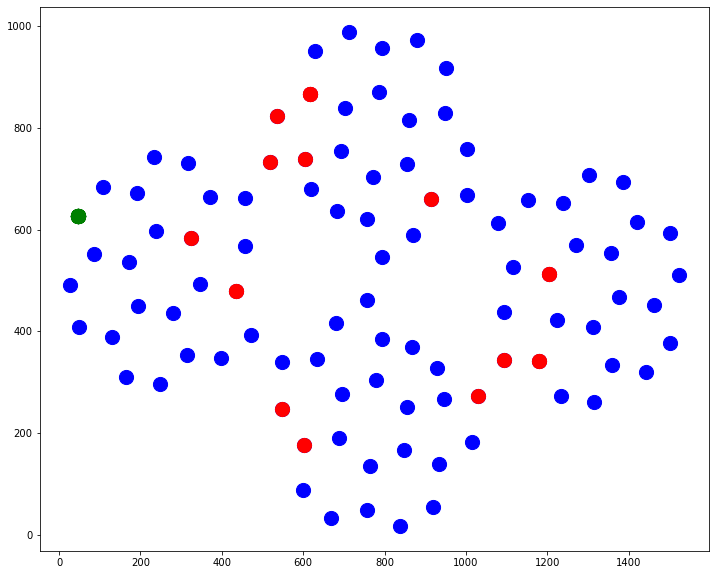

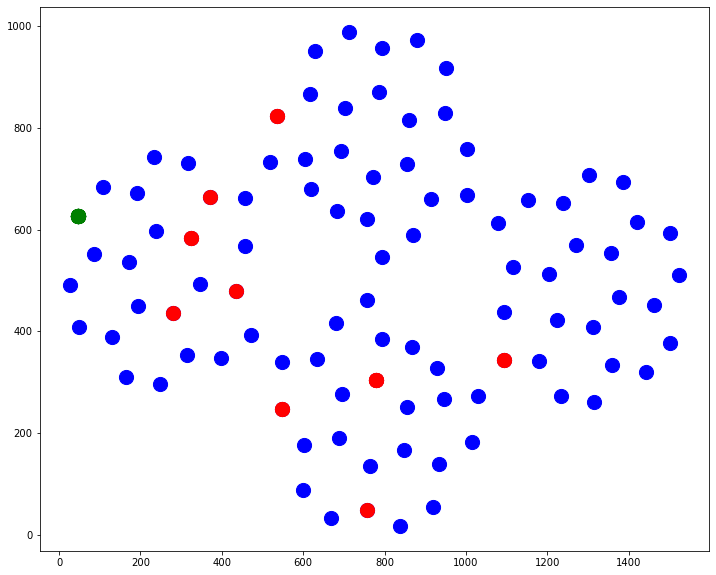

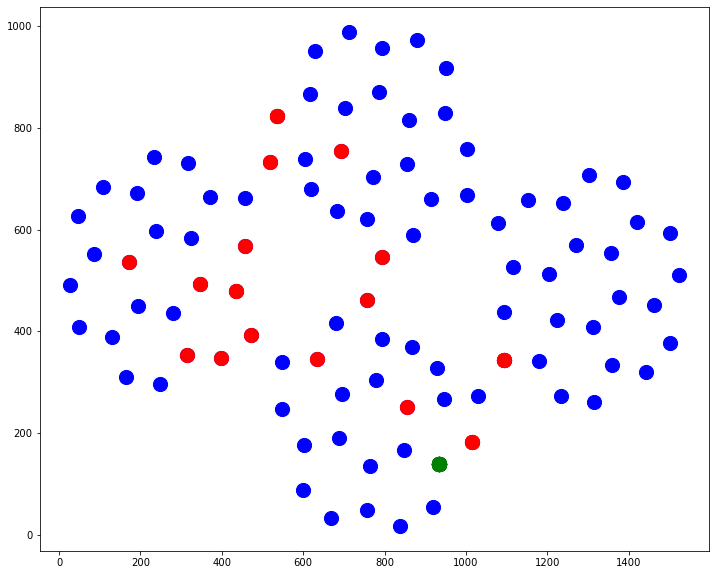

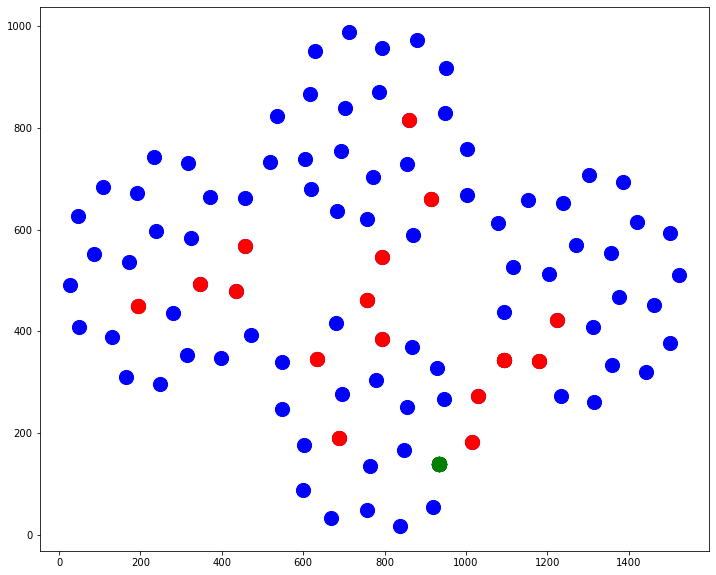

In [69]:
v=0

for i in (dataFram['session_number'].unique()):
    n = dataFram.loc[dataFram['session_number']==i] 
    plt.figure(figsize=(12,10))
    
    for nn in pos.keys():
        plt.scatter(pos[nn][0],pos[nn][1],s=200,c='b')

    for tr in range(len(n)):
        node_lbls = n.loc[tr+v,'intersection_node']
        node_goal = n.loc[tr+v,'goal_node']
        #p = 100*np.array(dictF[node_lbls])
        plt.scatter(pos[str(node_lbls)][0],pos[str(node_lbls)][1],s=200,c='red')#
        plt.scatter(pos[str(node_goal)][0],pos[str(node_goal)][1],s=200,c='green')#
        #plt.scatter(pos[str(node_lbls)][0],pos[str(node_lbls)][1],s=p,c='red')#
#         plt.scatter(pos[str(node_goal)][0],pos[str(node_goal)][1],s=200,c='green')#
    v+=len(n)
    plt.show() 
    
#Generalizeer naar alles van een rat (of sessie) in een plot. Dat kan door een dictionary te maken van de aantal keer dat iets een intersectiepunt is.
#Daarna kijken of je de grootte van de bolletjes kan laten uitmaken voor wanneer iets vaak voorkomt.
#Daarna, doen voor alle animals.
#We willen uiteindelijk zien of de dieren altijd bij dezelfde cue uitvogelen waar ze zijn, of altijd op X stappen vanaf de goal location. En we willen kijken hoevaak ze de bruggen gebruiken. 